# TSS Analysis

This notebook will calculate the distance of each ATAC peak to the closest transcription start site (TSS). It will save the results to _data-processed/peaks_annotated.csv_ adding the columns *dist_to_TSS*, *TSS_GeneName*, *is_promoter*, *is_enhancer*, *is_intragenic*, *is_extragenic*.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from scipy.stats import ttest_ind, spearmanr

DATA_DIR = "data/"
DATA_PROC_DIR = "data-processed/"
ATAC_SEQ_PATH = os.path.join(DATA_DIR, "ImmGenATAC18_AllOCRsInfo.csv")
REFFLAT_PATH = os.path.join(DATA_DIR, "refFlat.txt.gz")
PROC_PEAKS_PATH = os.path.join(DATA_PROC_DIR, "peaks_annotated.csv")

# Load ATAC-seq data
atac = pd.read_csv(ATAC_SEQ_PATH, index_col=[0,1,2])
atac.index.names = ["id","chrom","summit"]
peaks = atac.reset_index()
# Load gene annotation data
refFlat = pd.read_csv(REFFLAT_PATH, sep="\t", header=None, compression="gzip")
refFlat.columns = ["geneName", "transcriptName", "chrom", "strand", "tx5p", "tx3p",
    "cdsStart", "cdsEnd", "exonCount", "exonStarts", "exonEnds"]

In [12]:
# Check if pre-processed peaks exist if not generate them
if not os.path.exists(PROC_PEAKS_PATH):
    # Compute TSS for each transcript:
    # If strand == "+", TSS = tx5p; if "-", TSS = tx3p
    refFlat["tss"] = np.where(refFlat["strand"] == "+",
                            refFlat["tx5p"],
                            refFlat["tx3p"])

    # Create per-chromosome list of (tss, geneName) tuples, sorted
    tss_by_chr = {
        chrom: sorted(zip(df["tss"], df["geneName"]))
        for chrom, df in refFlat.groupby("chrom")
    }

    # === 3. Distance + GeneName function ===
    def nearest_tss_and_gene(chrom, pos):
        if chrom not in tss_by_chr:
            return (np.nan, None)
        entries = tss_by_chr[chrom]
        tss_pos = [t[0] for t in entries]
        idx = np.searchsorted(tss_pos, pos)

        closest_dist = float("inf")
        closest_gene = None

        # Check the previous TSS
        if idx > 0:
            dist = abs(pos - tss_pos[idx - 1])
            if dist < closest_dist:
                closest_dist = dist
                closest_gene = entries[idx - 1][1]

        # Check the current/next TSS
        if idx < len(tss_pos):
            dist = abs(pos - tss_pos[idx])
            if dist < closest_dist:
                closest_dist = dist
                closest_gene = entries[idx][1]

        return (closest_dist, closest_gene)

    
    # Annotate each peak
    dists = []
    is_promoter = []
    is_intragenic = []
    geneNames = []

    # pre-group gene intervals per chromosome
    genes_by_chr = {c: g[["cdsStart","cdsEnd"]].values for c,g in refFlat.groupby("chrom")}

    for _, row in peaks.iterrows():
        chrom, summit = row["chrom"], row["summit"]

        # distance to nearest TSS
        d, name = nearest_tss_and_gene(chrom, summit)
        dists.append(d)
        geneNames.append(name)

        # promoter if within ±1kb
        is_promoter.append(abs(d) <= 1000)

        # intragenic if center falls within any gene interval
        intr = False
        for gs, ge in genes_by_chr.get(chrom, []):
            if gs <= summit <= ge:
                intr = True
                break
        is_intragenic.append(intr)

    # attach to peaks DataFrame
    peaks["dist_to_TSS"]   = dists
    peaks["TSS_GeneName"]  = geneNames
    peaks["is_promoter"]   = is_promoter
    peaks["is_enhancer"]   = ~peaks["is_promoter"]
    peaks["is_intragenic"] = is_intragenic
    peaks["is_extragenic"] = ~peaks["is_intragenic"]

    # Save annotated peaks
    peaks.to_csv(PROC_PEAKS_PATH, index=False)
else: # Otherwise load pre-processed peaks
    peaks = pd.read_csv(PROC_PEAKS_PATH)

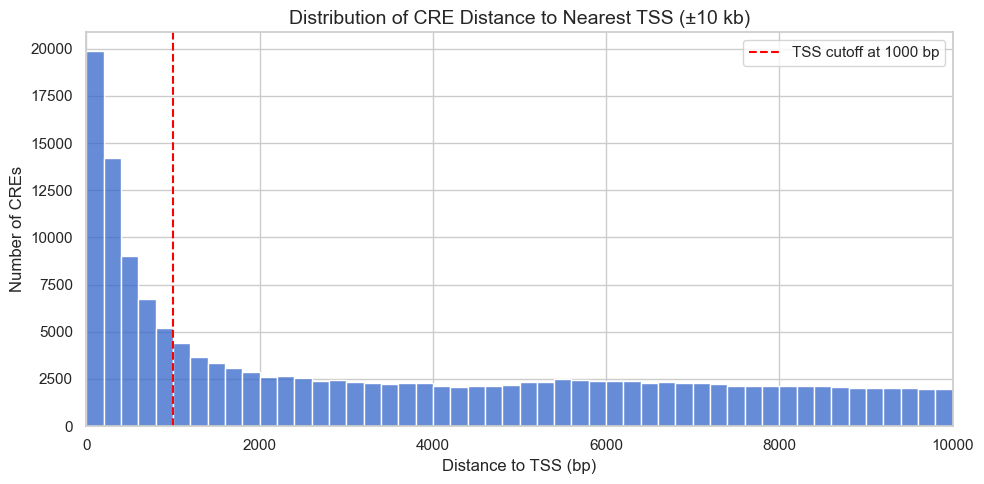

In [ ]:
# Plot the distribution of distances to TSS
# Remove NaNs and limit extreme values for better plot scale
distances = peaks["dist_to_TSS"].dropna()
distances = distances[distances.abs() <= 1e4]  # only +/-10 kb

plt.figure(figsize=(10, 5))
sns.histplot(distances, bins=50, color="#3366cc")

plt.axvline(1000, color="red", linestyle="--", label="TSS cutoff at 1000 bp")
plt.xlim(0, 10000)

plt.title("Distribution of CRE Distance to Nearest TSS (±10 kb)", fontsize=14)
plt.xlabel("Distance to TSS (bp)", fontsize=12)
plt.ylabel("Number of CREs", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

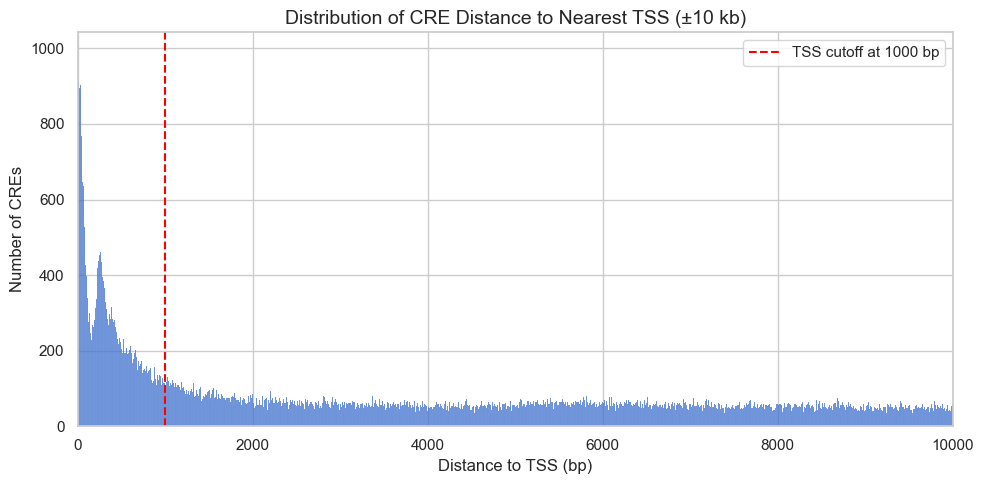

In [ ]:
# Plot the distribution of distances to TSS
# Remove NaNs and limit extreme values for better plot scale
distances = peaks["dist_to_TSS"].dropna()
distances = distances[distances.abs() <= 1e4]  # only +/-10 kb

plt.figure(figsize=(10, 5))
sns.histplot(distances, bins=2000, color="#3366cc")

plt.axvline(1000, color="red", linestyle="--", label="TSS cutoff at 1000 bp")
plt.xlim(0, 10000)

plt.title("Distribution of CRE Distance to Nearest TSS (±10 kb)", fontsize=14)
plt.xlabel("Distance to TSS (bp)", fontsize=12)
plt.ylabel("Number of CREs", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

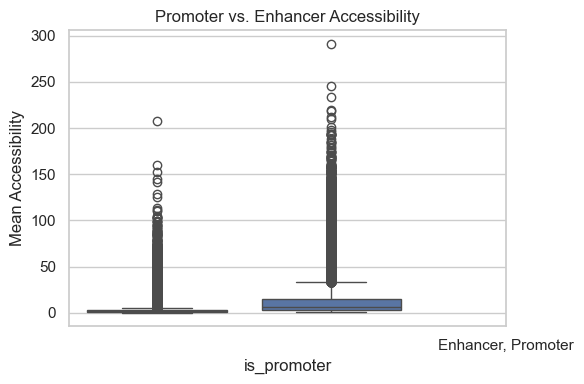

In [ ]:
# Compute per‐cell stats
peaks["mean_access"] = atac.mean(axis=1, numeric_only=True).values

plt.figure(figsize=(6,4))
sns.boxplot(x="is_promoter", y ="mean_access", data=peaks)
plt.xticks(["Enhancer, Promoter"])
plt.ylabel("Mean Accessibility")
plt.title("Promoter vs. Enhancer Accessibility")
plt.tight_layout()
plt.show()

In [ ]:
prom_vals = peaks.loc[peaks.is_promoter, "mean_access"].dropna()
enh_vals = peaks.loc[~peaks.is_promoter, "mean_access"].dropna()
# Remove any inf or nan values before t-test
prom_vals_clean = prom_vals[np.isfinite(prom_vals)]
enh_vals_clean = enh_vals[np.isfinite(enh_vals)]
tstat, pval = ttest_ind(prom_vals_clean, enh_vals_clean, equal_var=False)
print(f"Promoter vs Enhancer t-test {tstat:.2f}, p-value: {pval:.2f}")

Promoter vs Enhancer t-test 128.33, p-value: 0.00


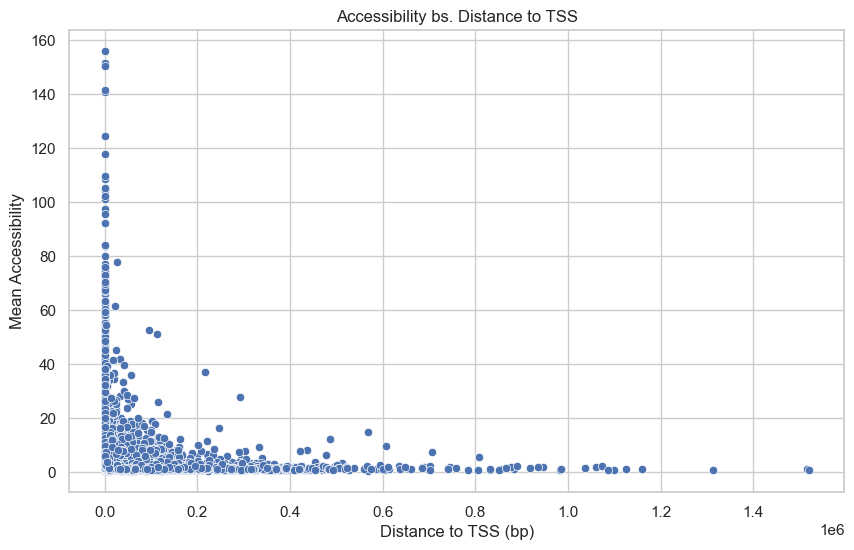

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="dist_to_TSS", y="mean_access", data=peaks.sample(10000))
plt.xlabel("Distance to TSS (bp)")
plt.ylabel("Mean Accessibility")
plt.title("Accessibility bs. Distance to TSS")
plt.show()

In [ ]:
rho, sp_p = spearmanr(peaks["dist_to_TSS"], peaks["mean_access"], nan_policy="omit")
print(f"Spearman rho (access vs dist): {rho:.2f}, p-value: {sp_p:.2f}")

Spearman rho (access vs dist): -0.31, p-value: 0.00


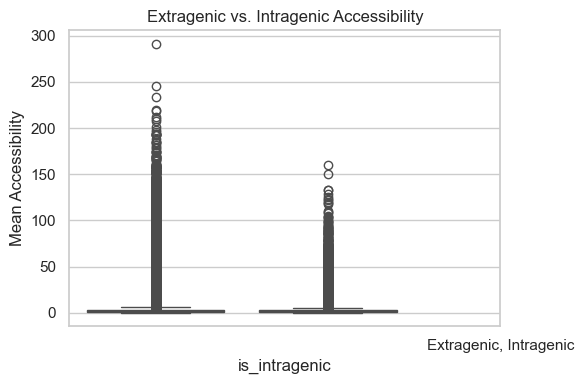

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x="is_intragenic", y ="mean_access", data=peaks)
plt.xticks(["Extragenic, Intragenic"])
plt.ylabel("Mean Accessibility")
plt.title("Extragenic vs. Intragenic Accessibility")
plt.tight_layout()
plt.show()

In [ ]:
intra = peaks.loc[peaks.is_intragenic, "mean_access"]
extra = peaks.loc[~peaks.is_intragenic, "mean_access"]
# Remove any inf or nan values before t-test
intra_vals_clean = intra[np.isfinite(intra)]
extra_vals_clean = extra[np.isfinite(extra)]
tstat2, pval2 = ttest_ind(intra_vals_clean, extra_vals_clean, equal_var=False)
print(f"Intragenic vs Extragenic t-test {tstat2}, p-value: {pval2}")

Intragenic vs Extragenic t-test -68.66983861744136, p-value: 0.0
